## Stimuli for Psychophysics Experiments based on fourier representation

In [15]:
%matplotlib inline

import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import scipy.fftpack
import scipy.signal
import skimage.transform
import warnings
from scipy import interpolate
#from tqdm import tqdm_notebook
import imp as imp

import utils.getstim as getstim

In [25]:
imp.reload(getstim)
stim_px_w = 1920
stim_px_h = 1080

#calc degrees and cpd
stim_deg = 2
stim_cpd = (stim_px_w/2)/stim_deg
print(f'Max stimulus resolution when viewed at {stim_deg}°: {stim_cpd:.1f} CPD')

Max stimulus resolution when viewed at 2°: 480.0 CPD


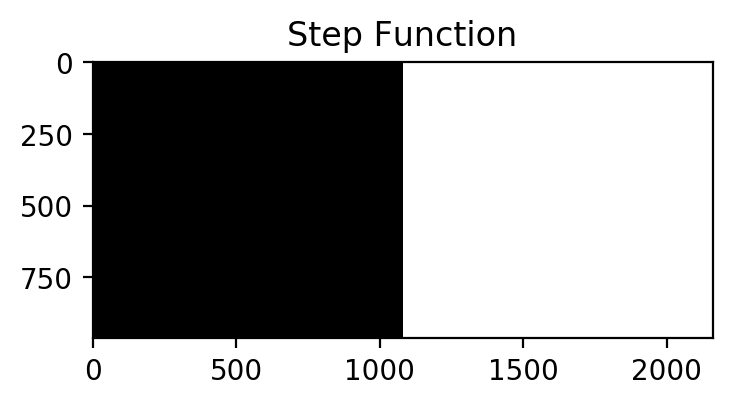

In [45]:
# Step function
#stim_step = np.hstack((np.ones((stim_pix, stim_pix//2)),
                       #np.zeros((stim_pix, stim_pix//2))))
imp.reload(getstim)
stim_step = getstim.step_stim(stim_px_w,stim_px_h,orient=1, stepdn=False)
f, ax = plt.subplots(1, 1, figsize=(4, 4))
ax.imshow(stim_step, cmap='Greys_r')
ax.set_title('Step Function')
plt.show()

/Users/stevecholewiak/.virtualenvs/m-fft_remove_higher_frequencies/lib/python3.6/site-packages/ipykernel_launcher.py:19: UserWarning: Cropped and resized image from (620, 826) to (300, 300)


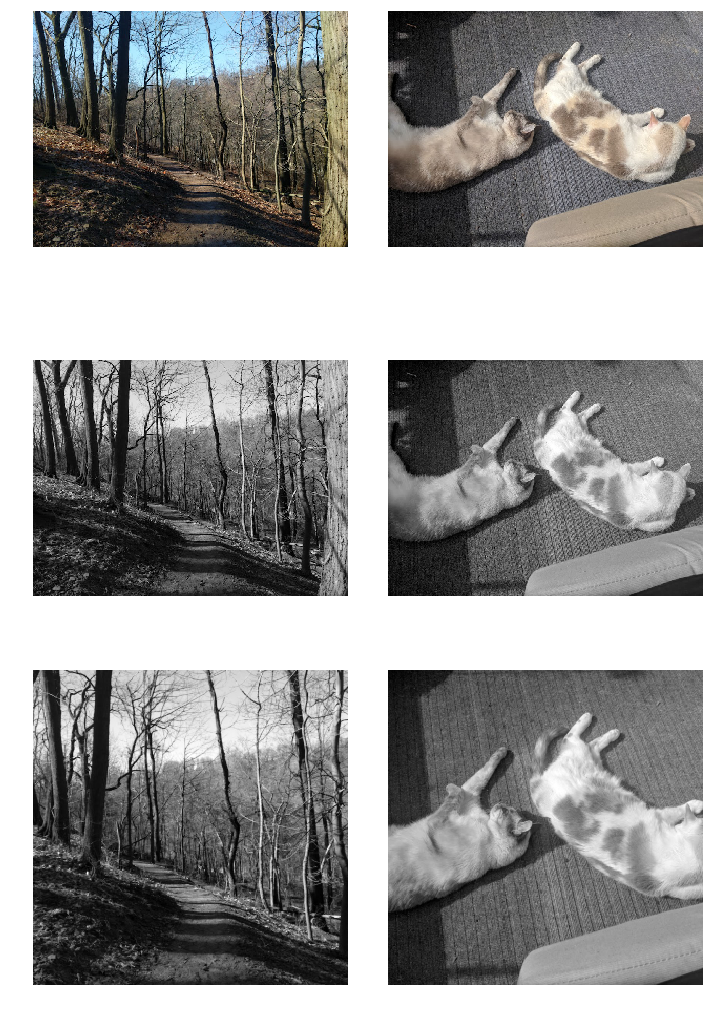

In [4]:
# Load images
trail = imageio.imread(os.path.join('ims', 'trail.jpg'))
cats = imageio.imread(os.path.join('ims', 'cats.jpg'))

# Convert to grayscale
def rgb2gray(rgb):
    # Convert to grayscale: https://stackoverflow.com/a/12201744
    return np.dot(rgb[...,:3], [0.299, 0.587, 0.114])

trail_gray = rgb2gray(trail)
cats_gray = rgb2gray(cats)

# Crop and resize
def cropnresize(img, imsize):
    img_out = img[img.shape[0]//2-np.min(img.shape[:2])//2:img.shape[0]//2+np.min(img.shape[:2])//2,
                  img.shape[1]//2-np.min(img.shape[:2])//2:img.shape[1]//2+np.min(img.shape[:2])//2]
    if img.shape[0] != imsize:
        img_out = skimage.transform.resize(img_out, (imsize, imsize), anti_aliasing=True, mode='reflect')
        warnings.warn(f'Cropped and resized image from {img.shape} to {img_out.shape}')
    return img_out
    
stim_trail = cropnresize(trail_gray, stim_pix)
stim_cats = cropnresize(cats_gray, stim_pix)

f, ax = plt.subplots(3, 2, figsize=(10, 15))
ax[0, 0].imshow(trail)
ax[0, 1].imshow(cats)
ax[1, 0].imshow(trail_gray, cmap='gray')
ax[1, 1].imshow(cats_gray, cmap='gray')
ax[2, 0].imshow(stim_trail, cmap='gray')
ax[2, 1].imshow(stim_cats, cmap='gray')
for r in range(ax.shape[0]):
    for c in range(ax.shape[1]):
        ax[r, c].axis('off')
plt.tight_layout()
plt.show()

/Users/stevecholewiak/.virtualenvs/m-fft_remove_higher_frequencies/lib/python3.6/site-packages/ipykernel_launcher.py:24: RuntimeWarning: divide by zero encountered in log


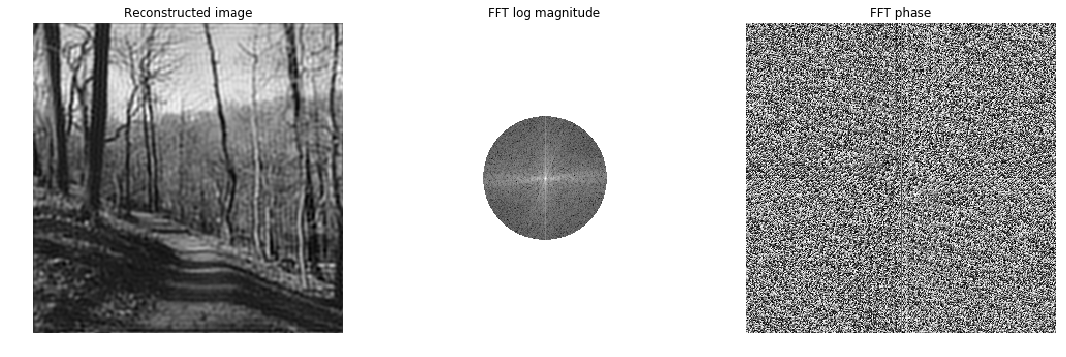

In [5]:
def fft_lowpass(img_in, cpd_cutoff, stim_cpd):
    if cpd_cutoff > stim_cpd:
        warnings.warn('Cutoff CPD is higher than stimulus CPD')
    fft_diameter = cpd_cutoff/(stim_cpd)
    img_size = img_in.shape[0]
    fft = np.fft.fftshift(np.fft.fft2(img_in))
    mag = np.abs(fft)
    xx, yy = np.meshgrid(np.linspace(-1, 1, img_size),
                         np.linspace(-1, 1, img_size))
    dist = np.sqrt(xx**2 + yy**2)
    # Anything greater than the cpd_cutoff will be set to 0 in the mag
    mag = mag * (dist < fft_diameter)
    phase = np.angle(fft)
    # Reconstruct the image using the inverse fourier transform
    ifft = np.fft.fftshift(mag * np.exp(phase * 1.0j))
    img_ifft = np.fft.ifft2(ifft).real
    
    return img_ifft, mag, phase

f, ax = plt.subplots(1, 3, figsize=(15, 5))
img, mag, phase = fft_lowpass(stim_trail, 30, stim_cpd)
ax[0].imshow(img, cmap='gray')
ax[0].set_title('Reconstructed image')
ax[1].imshow(np.log(mag), cmap='gray')
ax[1].set_title('FFT log magnitude')
ax[2].imshow(phase, cmap='gray')
ax[2].set_title('FFT phase')
for c in range(ax.shape[0]):
    ax[c].axis('off')
plt.tight_layout()
plt.show()

/Users/stevecholewiak/.virtualenvs/m-fft_remove_higher_frequencies/lib/python3.6/site-packages/ipykernel_launcher.py:3: UserWarning: Cutoff CPD is higher than stimulus CPD
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/stevecholewiak/.virtualenvs/m-fft_remove_higher_frequencies/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in log
  if __name__ == '__main__':


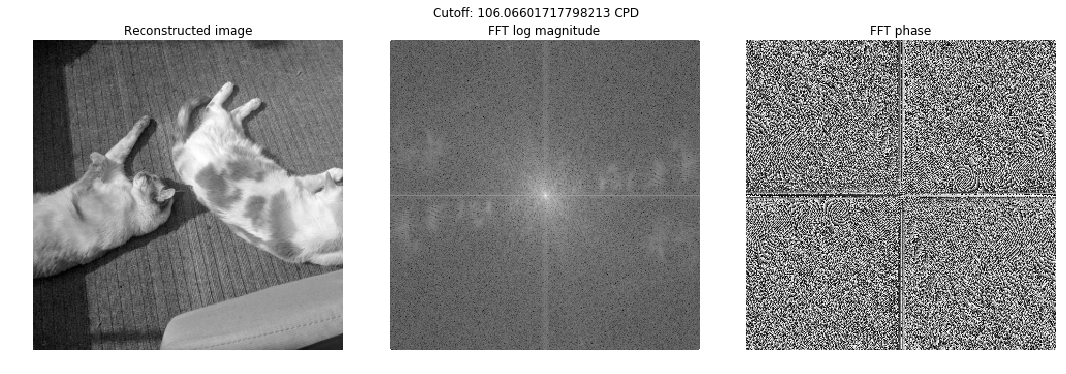

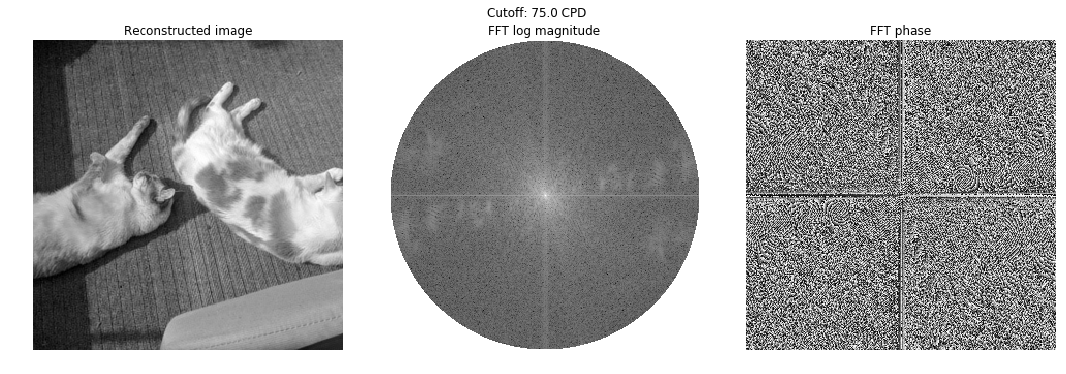

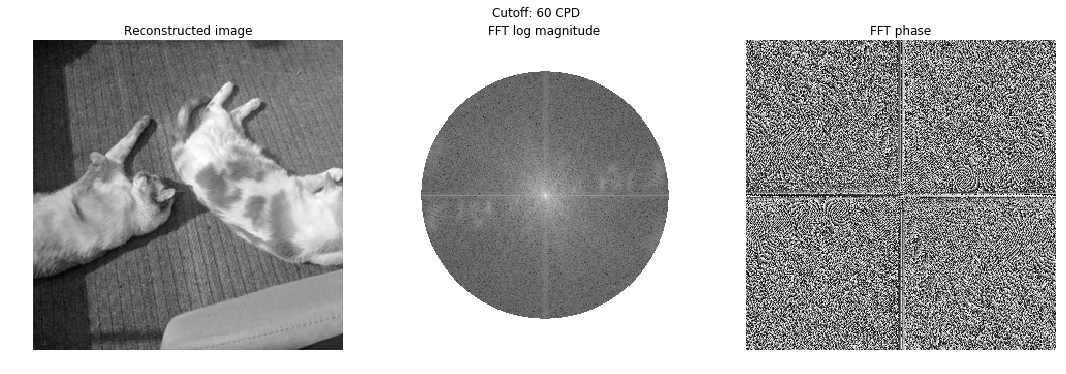

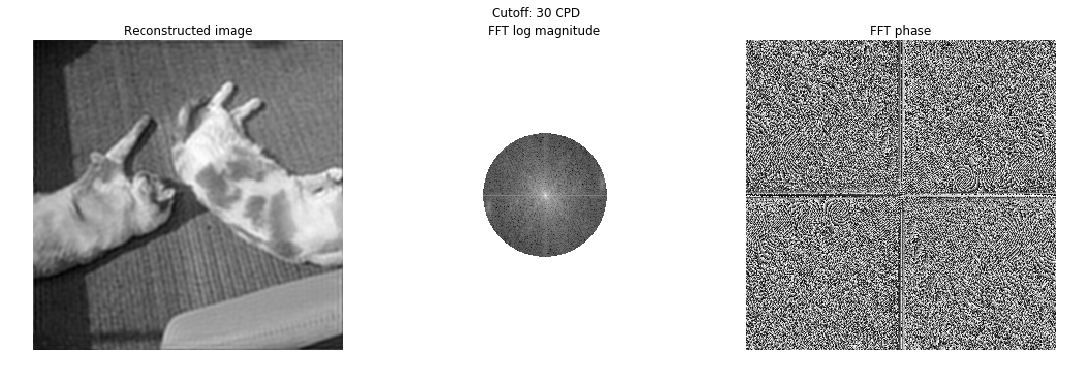

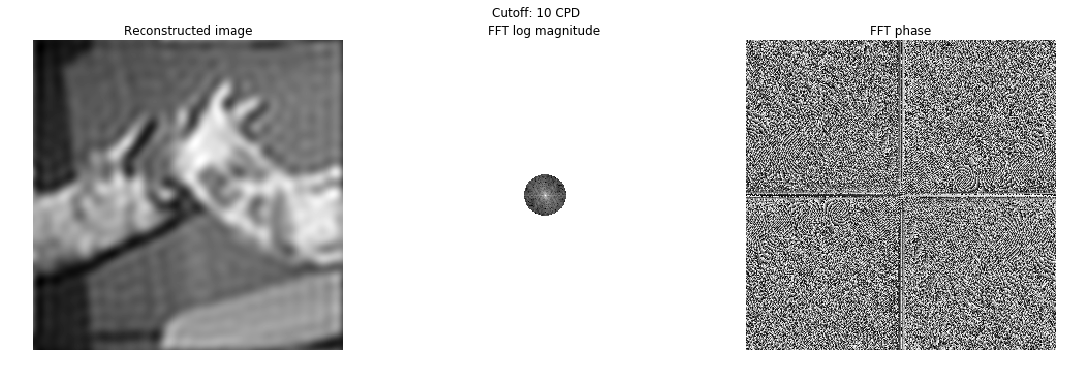

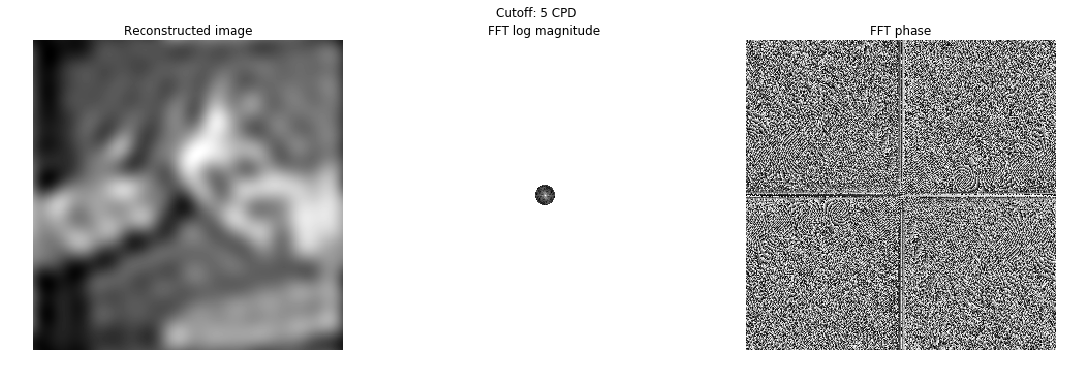

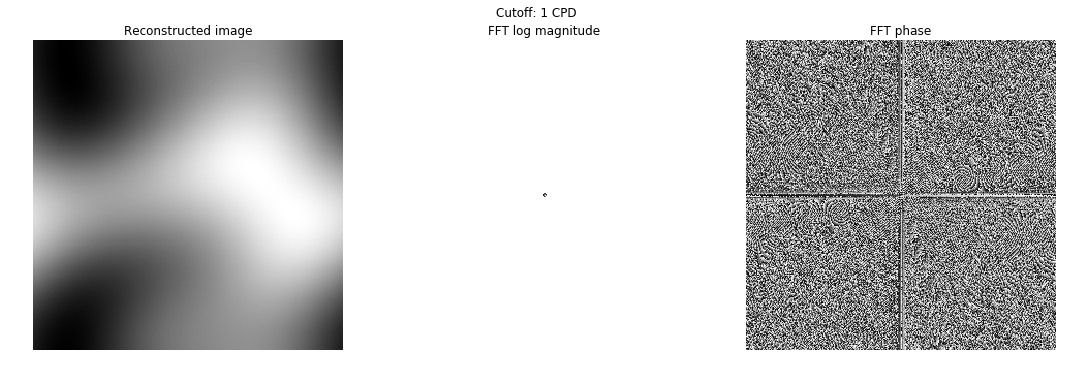

In [6]:
# Visualize the FFT magnitudes and phases for different cutoffs

cutoffs = [np.sqrt(2)*stim_cpd, stim_cpd, 60, 30, 10, 5, 1]
for idx, cut in enumerate(cutoffs):
    f, ax = plt.subplots(1, 3, figsize=(15, 5))
    img, mag, phase = fft_lowpass(stim_cats, cut, stim_cpd)
    ax[0].imshow(img, cmap='gray')
    ax[0].set_title('Reconstructed image')
    ax[1].imshow(np.log(mag), cmap='gray')
    ax[1].set_title('FFT log magnitude')
    ax[2].imshow(phase, cmap='gray')
    ax[2].set_title('FFT phase')
    for c in range(ax.shape[0]):
        ax[c].axis('off')
    plt.suptitle(f'Cutoff: {cut} CPD', y=1.025)
    plt.tight_layout()
    plt.show()

/Users/stevecholewiak/.virtualenvs/m-fft_remove_higher_frequencies/lib/python3.6/site-packages/ipykernel_launcher.py:3: UserWarning: Cutoff CPD is higher than stimulus CPD
  This is separate from the ipykernel package so we can avoid doing imports until


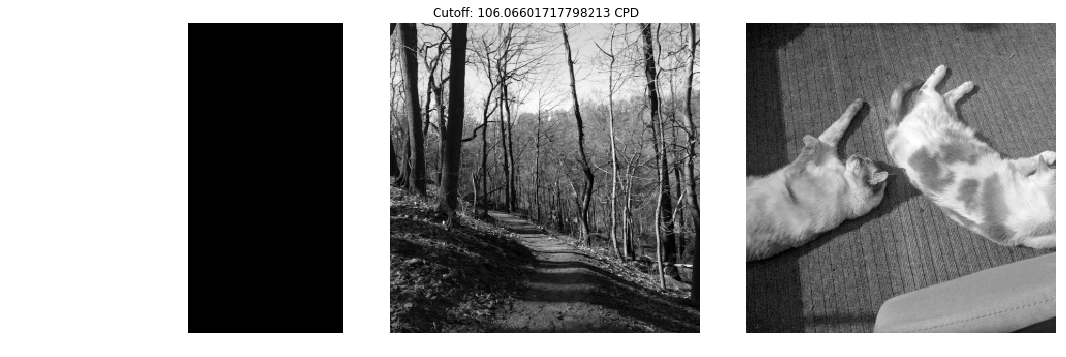

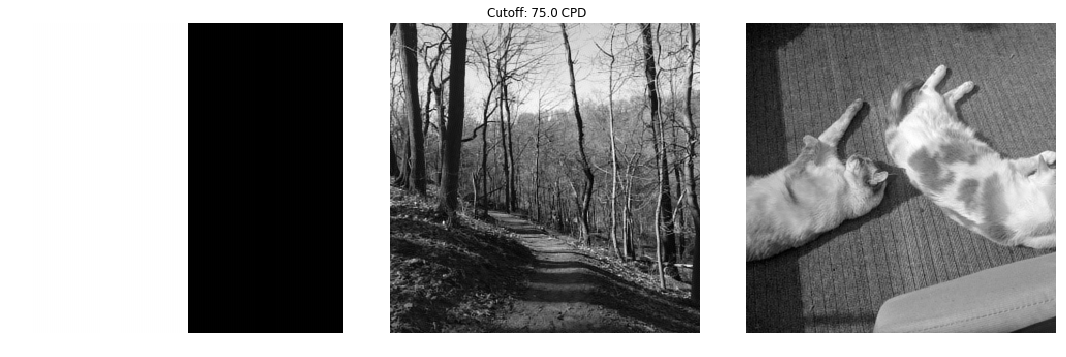

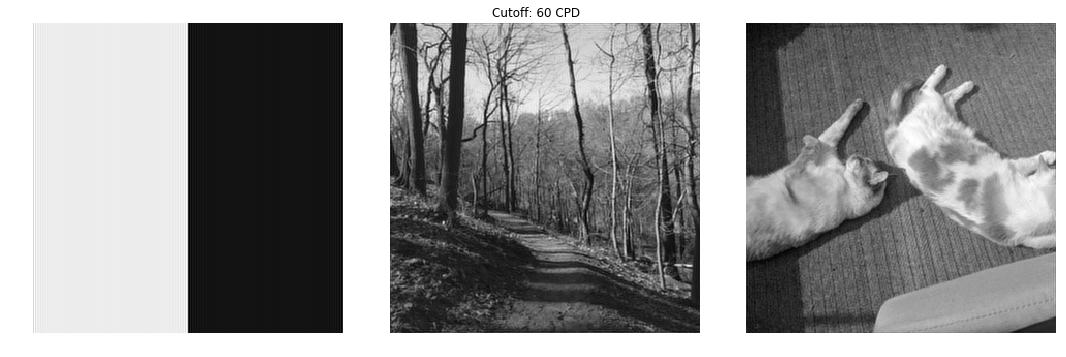

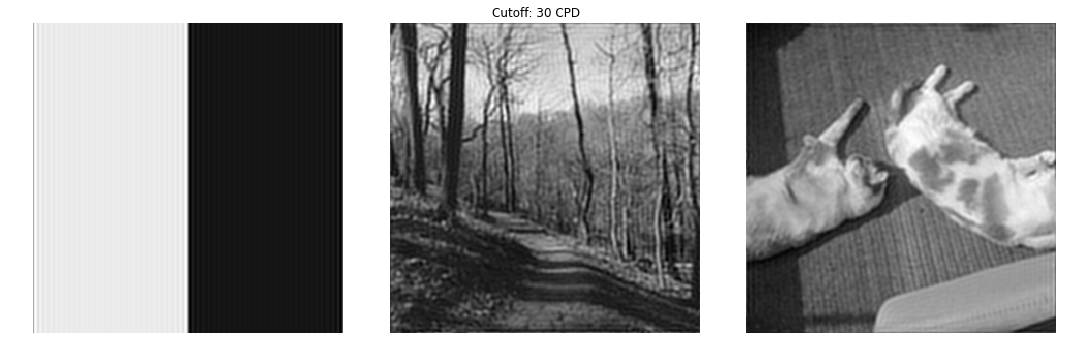

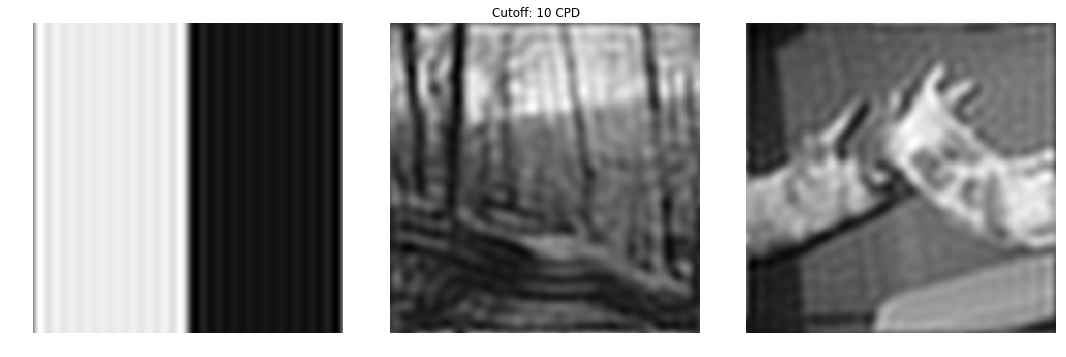

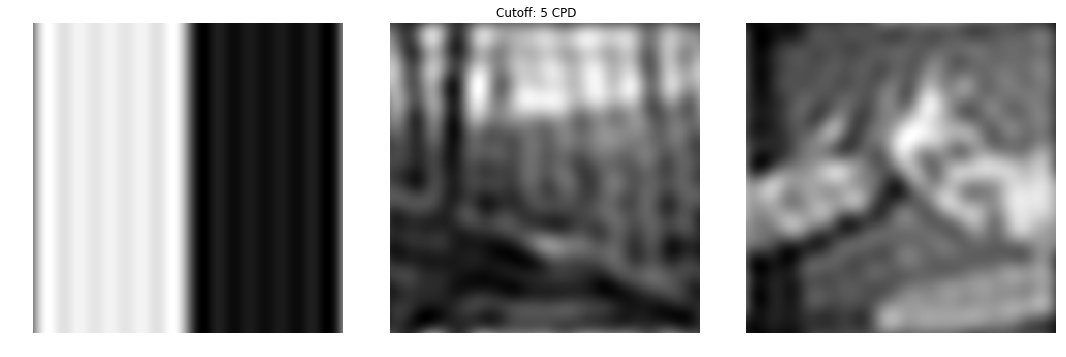

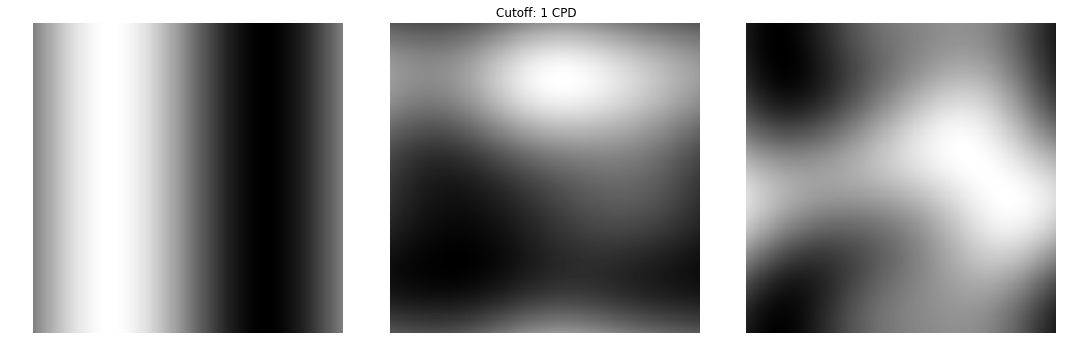

In [7]:
# Visualize reconstuctions for different images

cutoffs = [np.sqrt(2)*stim_cpd, stim_cpd, 60, 30, 10, 5, 1]
for idx, cut in enumerate(cutoffs):
    f, ax = plt.subplots(1, 3, figsize=(15, 5))
    ax[0].imshow(fft_lowpass(stim_step, cut, stim_cpd)[0], cmap='gray')
    ax[1].imshow(fft_lowpass(stim_trail, cut, stim_cpd)[0], cmap='gray')
    ax[2].imshow(fft_lowpass(stim_cats, cut, stim_cpd)[0], cmap='gray')
    for c in range(ax.shape[0]):
        ax[c].axis('off')
    plt.suptitle(f'Cutoff: {cut} CPD')
    plt.tight_layout()
    plt.show()